In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
import os

np.random.seed(123)

%matplotlib inline
plt.style.use('ggplot')

import matplotlib

text_size = 20

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['axes.titlesize'] = text_size
matplotlib.rcParams['axes.labelsize'] = text_size - 2
matplotlib.rcParams['xtick.labelsize'] = text_size - 4
matplotlib.rcParams['ytick.labelsize'] = text_size - 4

/usr/local/lib/python3.4/dist-packages/joblib/_multiprocessing_helpers.py:29: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


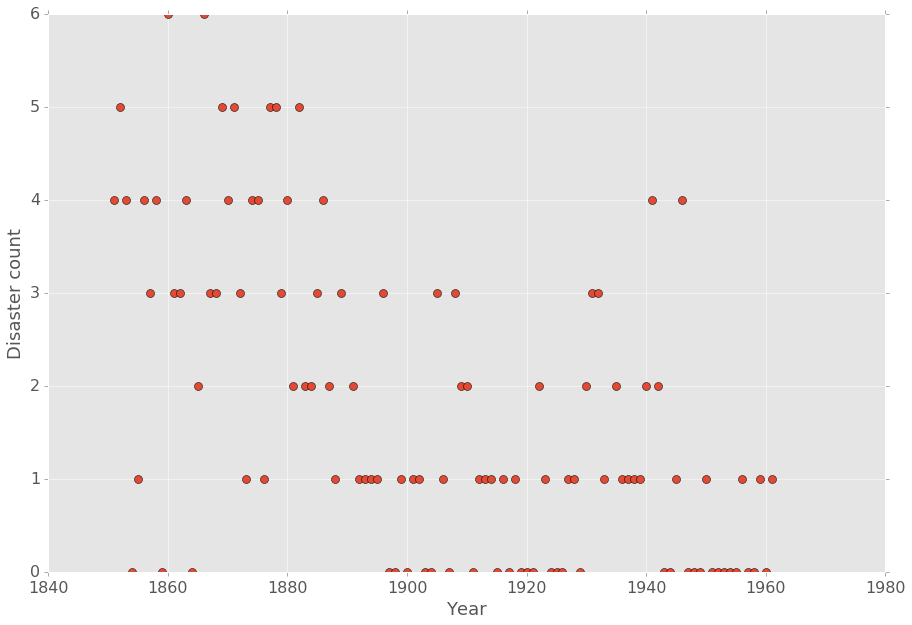

In [6]:
disaster_data = np.ma.masked_values([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                                     3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                                     2, 2, 3, 4, 2, 1, 3, -999, 2, 1, 1, 1, 1, 3, 0, 0,
                                     1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                                     0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                                     3, 3, 1, -999, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                                     0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1], 
                                    value=-999)

year = np.arange(1851, 1962)

plt.plot(year, disaster_data, 'o', markersize=8);
plt.ylabel("Disaster count")
plt.xlabel("Year")

# Model:

### $D_t \sim \text{Pois}(r_t) $ (`Poisson`)

* $D_t$ is the number of disasters in year $t$;

### $r_t = \begin{cases}
    l,& \text{if } t\lt s\\
    e,& \text{if } t\geq s \end{cases}$ (`switch`)
    
* $r_t$ is a deterministic random variable -- it depends on the switchpoint $s$;

### $s \sim \text{Unif}(t_l, t_h)$  (`DiscreteUniform`)

* $s$ is the year in which the rate parameter changes (the switchpoint);
* $t_l,t_h$ are the lower and upper boundaries of the year $t$;

### $e \sim \exp(1)$ (`Exponential`)

* $e$ is the rate parameter before the switchpoint;

### $l \sim \exp(1)$ (`Exponential`)

* $l$ is the rate parameter after the switchpoint $s$





In [5]:
from pymc3 import Model, Exponential, DiscreteUniform, Poisson, switch

with Model() as disaster_model:

    switchpoint = DiscreteUniform('switchpoint', lower=year.min(), upper=year.max(), testval=1900)

    # Priors for pre- and post-switch rates number of disasters
    early_rate = Exponential('early_rate', 1)
    late_rate = Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = switch(switchpoint >= year, early_rate, late_rate) # a Theano function; `switch` uses the first argument to choose the second or third argument

    disasters = Poisson('disasters', rate, observed=disaster_data)
    # Behind the scenes, another random variable, `disasters.missing_values` is created to model the missing values. 
    # All we need to do to handle the missing values is ensure we sample this random variable as well (see below).

Applied log-transform to early_rate and added transformed early_rate_log to model.
Applied log-transform to late_rate and added transformed late_rate_log to model.


In [12]:
from pymc3 import NUTS, Metropolis, sample

with disaster_model:
    # Each new sample is generated by first applying `step1` then `step2`.
    
    step1 = NUTS([early_rate, late_rate])

    # Use `Metropolis` for switchpoint, and missing values since it accommodates discrete variables
    step2 = Metropolis([switchpoint, disasters.missing_values[0]] )
    # We use `Metropolis` instead of `NUTS`, because `disasters` is a discreet random variable with no meaningful gradient

    trace = sample(100000, step=[step1, step2])

 [-----------------100%-----------------] 100000 of 100000 complete in 128.0 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f243f74d4a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f2445279630>]], dtype=object)

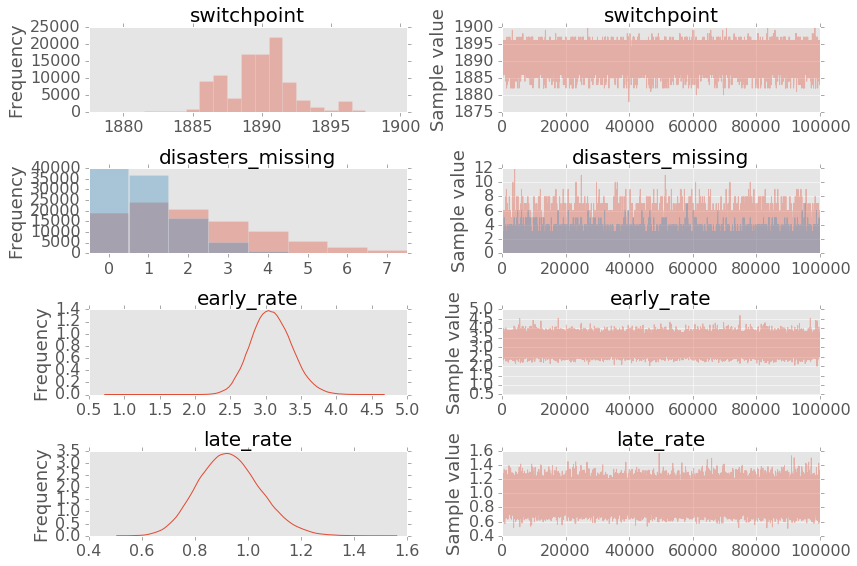

In [13]:
from pymc3 import traceplot
traceplot(trace)